In [1]:
from keras import backend as K  
#K.set_image_dim_ordering('th') 
K.image_data_format() == 'channels_last'
import os
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# from PIL import Image
import numpy as np
from keras.models import Sequential
import cv2
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import GlobalMaxPooling2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, GlobalMaxPool2D
from random import shuffle
from keras.models import load_model
from time import strftime, localtime
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
import  matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Input Image dimension : 28*28
IMAGE_SIZE = 28

# Control how many threads tensorflow uses.
THREAD_NUM = 1

In [3]:
# Util function to print time.
def printTime():
    tmpTime = localtime()
    print(strftime("%Y-%m-%d %H:%M:%S", tmpTime))
    return tmpTime

In [4]:
# Load data for testing from ./dataset/test/
# Returns np arrays
def load_test():
    tran_imags = []
    labels = []
    seq_names = ['man', 'woman']
    for seq_name in seq_names:
        frames = sorted(os.listdir(os.path.join(
            './', 'dataset', 'test', seq_name)))
        for frame in frames:
            imgs = [os.path.join('./', 'dataset', 'test', seq_name, frame)]
            img = cv2.imread(imgs[0])

            # Convert to grey scaled image and resize to 28*28
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
            imgs = np.array(img)
            tran_imags.append(imgs)
            if seq_name == 'man':
                labels.append(0)
            else:
                labels.append(1)
    return np.array(tran_imags), np.array(labels)

In [5]:
# Load data for training from ./dataset/train/
# Returns arrays
def load_train():
    tran_imags = []
    labels = []
    seq_names = ['man', 'woman']
    for seq_name in seq_names:
        frames = sorted(os.listdir(os.path.join(
            './', 'dataset', 'train', seq_name)))
        for frame in frames:
            imgs = [os.path.join('./', 'dataset', 'train', seq_name, frame)]
            img = cv2.imread(imgs[0])
            # Convert to grey scaled image and resize to 28*28
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
            imgs = np.array(img)
            tran_imags.append(imgs)
            if seq_name == 'man':
                labels.append(0)
            else:
                labels.append(1)
    return tran_imags, labels

In [6]:
def manOrWoman(predictedResult, index):
    if predictedResult[index][0]>predictedResult[index][1]:
        return 'man'
    else:
        return 'woman'

In [7]:
if __name__ == "__main__":

    print('\n\nStart training with %d threads.\n\n' % THREAD_NUM)
    # Initial tensorflow session with indicated threads count.
    with tf.Session(config=tf.ConfigProto( inter_op_parallelism_threads=1, intra_op_parallelism_threads=THREAD_NUM)) as sess:
        K.set_session(sess)
        train_data, train_label = load_train()
        index = []

        # Shuffle data every time to get different train/validate dataset.
        for i in range(1,len(train_data)):
            index.append(i)
        shuffle(index)
        shuffled_train_data =[]
        shuffled_train_label =[]
        for i,v in enumerate(index):
            shuffled_train_data.append(train_data[v])
            shuffled_train_label.append(train_label[v])
        shuffled_train_data = np.array(shuffled_train_data)
        shuffled_train_label = np.array(shuffled_train_label)
        # Construct ANN model
        model = Sequential()
        model.add(Flatten())
        model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_shape=(28, 28, 1)))
        model.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
        model.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'softmax'))
        model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
        
        # Normalize input
        shuffled_train_data = shuffled_train_data.reshape(shuffled_train_data.shape[0],28,28,1)/255
        print('\n\nStart at ')
        start_time = printTime()
        print("\n")

        # Train with 15 epochs, which leads to a nearly converged result. 
        # The validation rate is set to 20% of the total training dataset.

        history = model.fit(shuffled_train_data, keras.utils.to_categorical(
            shuffled_train_label), batch_size=32, epochs=15, verbose=1, shuffle=True,validation_split=0.2)

        print('\n\nEnd at ')
        end_time = printTime()

        # Save the trained model.
        model.save('my_ann_model.h5')
        loaded_model = load_model('my_ann_model.h5')
        test_data, test_label = load_test()
        test_data = test_data.reshape(test_data.shape[0],28,28,1)/255
        # Predict the test dataset and summary the value
        result = model.predict(test_data)
        resultStats = [0,0,0,0]

        for i,r in enumerate(result):
            print('truth: man' if test_label[i]==0 else 'truth: woman')
            if r[0]>r[1]:
                 print('predicted: man')
            else:
                 print('predicted: woman')



Start training with 1 threads.




Start at 
2020-04-12 17:27:21



Train on 1551 samples, validate on 388 samples
Epoch 1/15
1551/1551 [==============================] - 0s 141us/step - loss: 0.6929 - accuracy: 0.5035 - val_loss: 0.6903 - val_accuracy: 0.6521
Epoch 2/15
1551/1551 [==============================] - 0s 46us/step - loss: 0.6842 - accuracy: 0.5867 - val_loss: 0.6658 - val_accuracy: 0.7629
Epoch 3/15
1551/1551 [==============================] - 0s 46us/step - loss: 0.6319 - accuracy: 0.7208 - val_loss: 0.5683 - val_accuracy: 0.7552
Epoch 4/15
1551/1551 [==============================] - 0s 48us/step - loss: 0.5170 - accuracy: 0.7698 - val_loss: 0.4633 - val_accuracy: 0.7758
Epoch 5/15
1551/1551 [==============================] - 0s 43us/step - loss: 0.4528 - accuracy: 0.7847 - val_loss: 0.4305 - val_accuracy: 0.7835
Epoch 6/15
1551/1551 [==============================] - 0s 43us/step - loss: 0.4317 - accuracy: 0.8008 - val_loss: 0.4150 - val_accuracy: 0.8015
Epoch 7/15
1

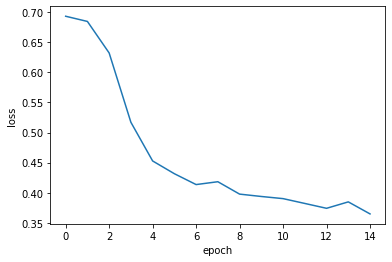

In [8]:
#plt loss
plt.figure()
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

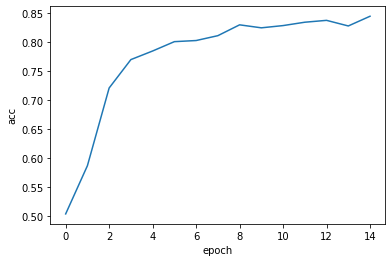

In [9]:
# plot accuracy
plt.plot(history.history['accuracy'])
plt.ylabel("acc")
plt.xlabel("epoch")
plt.show()

In [10]:
#Evaluate
for i,r in enumerate(result):
    if(test_label[i]==0):
        if r[0]>r[1]:
            resultStats[0] +=1
        else:
            resultStats[1] +=1
    else:
        if r[0]>r[1]:
            resultStats[2] +=1
        else:
            resultStats[3] +=1

print("test dataset prediction result by ANN:")
print("Man :")
print("\tGround truth: ", resultStats[0]/(resultStats[0]+resultStats[1]))
print("\tFalse positive: ", resultStats[2]/(resultStats[2]+resultStats[3]))

print("Woman :")
print("\tGround truth: ", resultStats[3]/(resultStats[2]+resultStats[3]))
print("\tFalse positive: ", resultStats[1]/(resultStats[0]+resultStats[1]))

test dataset prediction result by ANN:
Man :
	Ground truth:  0.8941176470588236
	False positive:  0.19411764705882353
Woman :
	Ground truth:  0.8058823529411765
	False positive:  0.10588235294117647
